# Import Data and Train Model


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from transformers import get_scheduler, AdamW
from datasets import load_metric

import numpy as np
import librosa

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import mne.channels
from tqdm.auto import tqdm
import random

torch.manual_seed(20)
np.random.seed(20)
random.seed(20)

## Load Data: Create Dataset


### Load Absence Seizure Data


In [203]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            a = np.load(row["labels"])
            for i, v in enumerate(a):
                a[i] = int(v)
            y_loaded.append(a)

            x_loaded.append(np.load(row["data"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        cleaned_x = []
        cleaned_y = []
        for i, v in enumerate(continuous_y):
            if v != "2":
                cleaned_x.append(continuous_x[i])
                cleaned_y.append(v)

        continuous_x = np.array(cleaned_x)
        continuous_y = np.array(cleaned_y)
        return continuous_x, continuous_y

In [208]:
# %%capture
# Load the dataset
seizure_type = "absence"
dataset = AbsenceDataset(
    f"processed_data/{seizure_type}/two_second_windows/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)
dataset.y = dataset.y.astype(int)

In [209]:
dataset.x.shape

(8292, 5, 500)

# Split Data

70%, 20%, 10%


In [210]:
dataset_len = len(dataset)
dataset_len

8292

In [211]:
aaaa = 0
for i, v in enumerate(dataset.y):
    if v == 1:
        aaaa += 1
aaaa

355

In [213]:
if (
    int(dataset_len * 0.7) + int(dataset_len * 0.2) + int(dataset_len * 0.1)
) != dataset_len:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(dataset_len * 0.7),
            int(dataset_len * 0.2),  # math.ceil
            int(dataset_len * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            int(dataset_len * 0.7),
            int(dataset_len * 0.1),
            int(dataset_len * 0.2),
        ],
    )

print(f"Train Split: {len(train_set)}")
print(f"Eval Split: {len(eval_set)}")
print(f"Test Split: {len(test_set)}")
print(f"Total: {len(train_set) + len(eval_set) + len(test_set)}")

Train Split: 5805
Eval Split: 1658
Test Split: 829
Total: 8292


In [214]:
train_set.dataset.x[train_set.indices].shape, train_set.dataset.y[
    train_set.indices
].shape

((5805, 5, 500), (5805,))

## SMOTE


In [215]:
bk, sz = (
    0,
    0,
)
for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // {seizure_type} Seizure: {sz}")

Background: 5547 // absence Seizure: 258


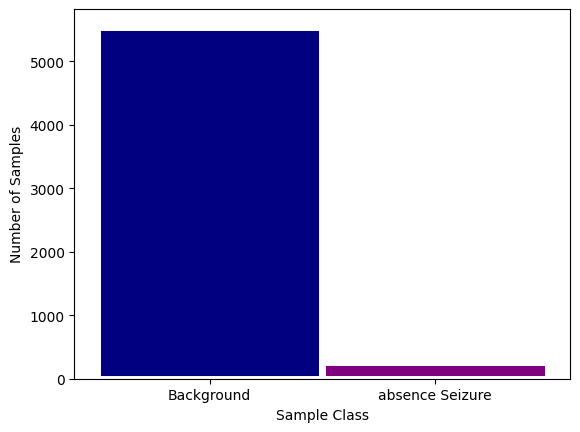

In [216]:
n, bins, p = plt.hist(
    train_set.dataset.y[train_set.indices],
    bins=2,
    edgecolor="white",
    linewidth=5,
    range=(0, 1),
)
plt.xticks([0.25, 0.75], ["Background", f"{seizure_type} Seizure"])
plt.ylabel("Number of Samples")
plt.xlabel("Sample Class")
p[0].set_facecolor("navy")
p[1].set_facecolor("purple")

In [217]:
shape = train_set.dataset.x[train_set.indices].shape
data_reshaped = train_set.dataset.x[train_set.indices]
data_reshaped = np.reshape(data_reshaped, (shape[0], shape[1] * shape[2]))
data_reshaped.shape

(5805, 2500)

In [218]:
train_set_x, train_set_y = SMOTE(
    sampling_strategy="not majority", random_state=42
).fit_resample(data_reshaped, train_set.dataset.y[train_set.indices])
# train_set_x = train_set.dataset.x[train_set.indices]
# train_set_y = train_set.dataset.y[train_set.indices]

In [219]:
# rand_us = RandomUnderSampler(random_state=42)
# train_set_x, train_set_y = rand_us.fit_resample(
#     data_reshaped, train_set.dataset.y[train_set.indices]
# )

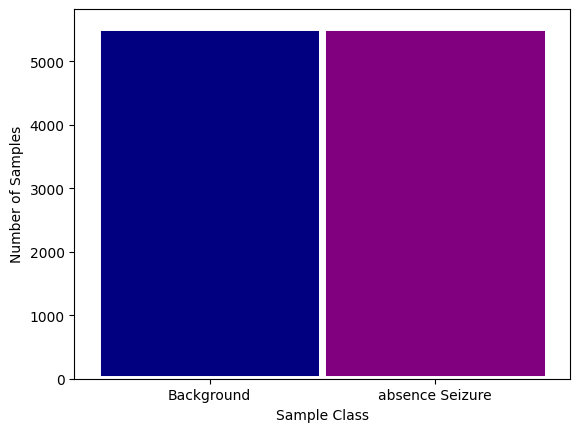

In [220]:
n, bins, p = plt.hist(
    train_set_y,
    bins=2,
    edgecolor="white",
    linewidth=5,
    range=(0, 1),
)

plt.xticks([0.25, 0.75], ["Background", f"{seizure_type} Seizure"])
plt.ylabel("Number of Samples")
plt.xlabel("Sample Class")
p[0].set_facecolor("navy")
p[1].set_facecolor("purple")

In [221]:
train_set_x = np.reshape(train_set_x, (train_set_x.shape[0], shape[1], shape[2]))
val_set_x = eval_set.dataset.x[eval_set.indices]
test_set_x = test_set.dataset.x[test_set.indices]
train_set_x.shape, val_set_x.shape, test_set_x.shape

((11094, 5, 500), (1658, 5, 500), (829, 5, 500))

In [222]:
bk, sz = 0, 0
for i, v in enumerate(train_set_y):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // {seizure_type} Seizure: {sz}")

Background: 5547 // absence Seizure: 5547


# STFT


Create STFT


In [327]:
n_fft = int(512 / 2)
window = "taylor"
hop_length = int(n_fft / 4)
fmin = 0
fmax = 30
n_mels = 25
sample_rate = 250
power = 3.0


# Train

stft_channel_data = []

for i, channels in enumerate(train_set_x):
    mels = librosa.feature.melspectrogram(
        y=channels,
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=n_fft,
        fmin=fmin,
        fmax=fmax,
        hop_length=hop_length,
        window=window,
        center=True,
        power=power,
    )
    # mels = np.log(mels + 1e-9)
    stft_channel_data.append((mels))

stft_channel_data = np.array(stft_channel_data)


# Val

val_stft_channel_data = []

for i, channels in enumerate(val_set_x):

    mels = librosa.feature.melspectrogram(
        y=channels,
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=n_fft,
        fmin=fmin,
        fmax=fmax,
        hop_length=hop_length,
        window=window,
        center=True,
        power=power,
    )
    # mels = np.log(mels + 1e-9)
    val_stft_channel_data.append((mels))

val_stft_channel_data = np.array(val_stft_channel_data)


# Test

test_stft_channel_data = []

for i, channels in enumerate(test_set_x):

    mels = librosa.feature.melspectrogram(
        y=channels,
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=n_fft,
        fmin=fmin,
        fmax=fmax,
        hop_length=hop_length,
        window=window,
        center=True,
        power=power,
    )
    # mels = np.log(mels + 1e-9)
    test_stft_channel_data.append((mels))

test_stft_channel_data = np.array(test_stft_channel_data)


stft_channel_data.shape, val_stft_channel_data.shape, test_stft_channel_data.shape

((11094, 5, 25, 8), (1658, 5, 25, 8), (829, 5, 25, 8))

In [328]:
# Train
train_db = []
for i, channels in enumerate(stft_channel_data):
    train_db.append(librosa.power_to_db((channels)))
train_db = np.array(train_db)

# Val
val_db = []
for i, channels in enumerate(val_stft_channel_data):
    val_db.append(librosa.power_to_db((channels)))
val_db = np.array(val_db)

# Test
test_db = []
for i, channels in enumerate(test_stft_channel_data):
    test_db.append(librosa.power_to_db((channels)))
test_db = np.array(test_db)

train_db.shape, val_db.shape, test_db.shape

((11094, 5, 25, 8), (1658, 5, 25, 8), (829, 5, 25, 8))

In [329]:
# Train
train_db_mean = []
for i, channels in enumerate(stft_channel_data):
    train_db_mean.append(np.mean(channels, axis=0))
train_db_mean = np.array(train_db_mean)

# Val
val_db_mean = []
for i, channels in enumerate(val_stft_channel_data):
    val_db_mean.append(np.mean(channels, axis=0))
val_db_mean = np.array(val_db_mean)

# Test
test_db_mean = []
for i, channels in enumerate(test_stft_channel_data):
    test_db_mean.append(np.mean(channels, axis=0))
test_db_mean = np.array(test_db_mean)

train_db_mean.shape, val_db_mean.shape, test_db_mean.shape

((11094, 25, 8), (1658, 25, 8), (829, 25, 8))

In [330]:
bbbb = []
for i, v in enumerate(train_set_y):
    if v == 1:
        bbbb.append(i)
bbbb[:15]

[4, 31, 48, 61, 89, 107, 121, 132, 139, 150, 156, 184, 204, 208, 215]

absence
0


([], [])

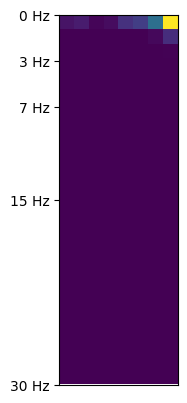

In [338]:
x = 142

print(seizure_type)


print(train_set_y[x])



plt.imshow(train_db_mean[x])

plt.yticks(

    [-0.5, (n_mels / 4) / 2 - 0.5, n_mels / 4 - 0.5, n_mels / 2 - 0.5, n_mels - 0.5],

    labels=[
        f"{fmin} Hz",
        f"{int(fmax/4/2)} Hz",
        f"{int(fmax/4)} Hz",
        f"{int(fmax/2)} Hz",
        f"{fmax} Hz",
    ],
)



plt.xticks([])



# plt.colorbar()
# librosa.display.specshow(train_db_mean[x])

Text(0.5, 1.0, 'Raw Channels: All 5 Channels')

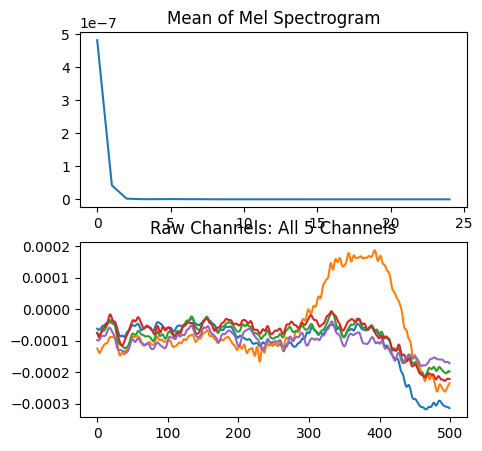

In [339]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(np.mean(train_db_mean[x], axis=1))
plt.title("Mean of Mel Spectrogram")
plt.subplot(2, 1, 2)
for i in train_set_x[x]:
    plt.plot(i)
plt.title("Raw Channels: All 5 Channels")

In [ ]:
n_mfcc = n_mels

mfccs_train = []
for i, channels in enumerate(train_db_mean):
    mfccs_train.append(
        librosa.feature.mfcc(
            S=channels,
            n_mfcc=n_mfcc,
        )
    )
mfccs_train = np.array(mfccs_train)

mfccs_val = []
for i, channels in enumerate(val_db_mean):
    mfccs_val.append(
        librosa.feature.mfcc(
            S=channels,
            n_mfcc=n_mfcc,
        )
    )
mfccs_val = np.array(mfccs_val)

mfccs_test = []
for i, channels in enumerate(test_db_mean):
    mfccs_test.append(
        librosa.feature.mfcc(
            S=channels,
            n_mfcc=n_mfcc,
        )
    )
mfccs_test = np.array(mfccs_test)

mfccs = librosa.feature.mfcc(S=train_db_mean[x], sr=250, n_mels=n_mels, fmax=30, fmin=0)
plt.xticks([])
plt.yticks([])
plt.imshow(mfccs)

Convert STFT to Image for Input


In [340]:
from skimage import io
from sklearn import preprocessing

In [341]:
# Output MFCC or Mel Spectrogram
to_image_train = train_db_mean  # mfccs_train
to_image_val = val_db_mean  # mfccs_val
to_image_test = test_db_mean  # mfccs_test

In [342]:
def sklearn_minnax(min, max, X):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [343]:
train_input_x = []
for i, melspec in enumerate(to_image_train):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    img = np.repeat(img[..., np.newaxis], 3, -1)
    img = np.transpose(img, (2, 0, 1))
    train_input_x.append(img.astype(np.uint8))
train_input_x = np.array(train_input_x)

val_input_x = []
for i, melspec in enumerate(to_image_val):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    img = np.repeat(img[..., np.newaxis], 3, -1)
    img = np.transpose(img, (2, 0, 1))
    val_input_x.append(img.astype(np.uint8))
val_input_x = np.array(val_input_x)

test_input_x = []
for i, melspec in enumerate(to_image_test):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    img = np.repeat(img[..., np.newaxis], 3, -1)
    img = np.transpose(img, (2, 0, 1))
    test_input_x.append(img.astype(np.uint8))
test_input_x = np.array(test_input_x)

# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image

0


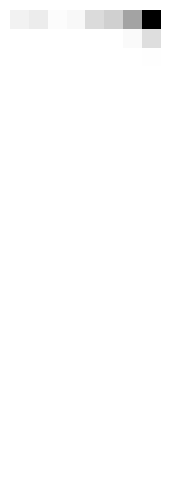

In [344]:
plt.figure(figsize=(5, 5))
plt.axis("off")

io.imshow(np.transpose(train_input_x[x], (1, 2, 0)))
print(train_set_y[x])

# Remake Dataset


In [345]:
class BalancedDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [346]:
train_dataset = BalancedDataset(
    (train_input_x, train_set_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
eval_dataset = BalancedDataset(
    (val_input_x, eval_set.dataset.y[eval_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
test_dataset = BalancedDataset(
    (test_input_x, test_set.dataset.y[test_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

In [347]:
# # Train
# train_db = []
# for i, channels in enumerate(stft_channel_data):
#     train_db.append(librosa.amplitude_to_db((channels), ref=np.max))
# train_db = np.array(train_db)

# # Val
# val_db = []
# for i, channels in enumerate(val_stft_channel_data):
#     val_db.append(librosa.amplitude_to_db((channels), ref=np.max))
# val_db = np.array(val_db)

# train_db.shape, val_db.shape

# DataLoaders


In [367]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
)
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=True)

# Model

Mobilenet


In [368]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [369]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [370]:
from torchvision.models import mobilenet_v2, mobilenet_v3_small, mobilenet_v3_large
from torchvision.models import shufflenet_v2_x1_0

In [376]:
# %%capture
model = shufflenet_v2_x1_0()
model.fc = nn.Linear(1024, 2)
model = nn.Sequential(
    model,
)
model = model.to(device)
model_name = "shufflenet"

c = 0
for i, v in enumerate((model.parameters())):
    c += 1
print(c)

model

170


Sequential(
  (0): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(5

In [372]:
%%capture
model = mobilenet_v3_small()
model.classifier[3] = nn.Linear(1024, 2)
model = nn.Sequential(
    model,
    nn.Softmax(dim=0),
)
model = model.to(device)
model_name = "mobilenet"

c = 0
for i, v in enumerate((model.parameters())):
    c += 1
print(c)

model

# Train


## Training Loop


### Print Inputs


In [373]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

bk = 0
sz = 0
for i, v in enumerate(train_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Train // Background: {bk} // {seizure_type} Seizure: {sz}")

bk = 0
sz = 0
for i, v in enumerate(eval_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Validation // Background: {bk} // {seizure_type} Seizure: {sz}")

Train // Background: 5547 // absence Seizure: 5547
Validation // Background: 1598 // absence Seizure: 60


### Training


In [377]:
num_epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCELoss()
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader),
)

In [378]:
print(device)
print(model_name)
print(seizure_type)

cuda
shufflenet
absence


In [379]:
progress_bar = tqdm(range(num_epochs * len(train_dataloader)))

100%|██████████| 17400/17400 [16:59<00:00, 17.07it/s]


In [380]:
progress_bar = tqdm(range(num_epochs * len(train_dataloader)))

print(f"Training {seizure_type} on {model_name} for {num_epochs} epochs")

tp, tn, fp, fn = 0, 0, 0, 0
actual, predicted = [], []

loss_track = []
valid_loss_track = []
for epoch in range(num_epochs):

    model.train()
    loss_batch = []
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.to(torch.int64)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step()
        progress_bar.update(1)

        loss_batch.append(loss.detach())

        del inputs, outputs, labels, loss

    model.eval()
    valid_loss_batch = []
    with torch.no_grad():
        for batch in eval_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.to(torch.int64)

            outputs = model(inputs)

            valid_loss_batch.append(loss_fn(outputs, labels).detach())

            outputs = nn.functional.softmax(outputs, dim=1)

            for i, v in enumerate(outputs):
                if labels[i] == torch.tensor([1]).to(device):
                    if v[1] > v[0]:
                        tp += 1
                    else:
                        fp += 1
                elif labels[i] == torch.tensor([0]).to(device):
                    if v[0] > v[1]:
                        tn += 1
                    else:
                        fn += 1

    loss_track.append(sum(loss_batch) / len(loss_batch))
    valid_loss_track.append(sum(valid_loss_batch) / len(valid_loss_batch))
    # break
    torch.cuda.empty_cache()

print("Done")

  0%|          | 2/34700 [00:00<37:39, 15.36it/s]

Training absence on shufflenet for 100 epochs


100%|██████████| 34700/34700 [25:21<00:00, 28.29it/s]  

Done


100%|██████████| 34700/34700 [25:39<00:00, 28.29it/s]

In [381]:
sensitivity = (tp) / (tp + fn)
specificity = (tn) / (tn + fp)
precision = (tp) / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Confusion Matrix:")
print(
    f"""
      ////                 Is Seizure, Is Not Seizure
      Is Seizure           {tp} ({round(tp/(tp + tn + fp + fn),2)}%)   {fp}({round(fp/(tp + tn + fp + fn),2)}%)
      Is Not Seizure       {fn} ({round(fn/(tp + tn + fp + fn),2)}%)   {tn}({round(tn/(tp + tn + fp + fn),2)}%)

      Sensitivity: {sensitivity}
      Specificity: {specificity}
      Precision: {precision}
      Accuracy: {accuracy}
      """
)

Confusion Matrix:

      ////                 Is Seizure, Is Not Seizure
      Is Seizure           5223 (0.03%)   777(0.0%)
      Is Not Seizure       7279 (0.04%)   152521(0.92%)

      Sensitivity: 0.4177731562949928
      Specificity: 0.9949314407232971
      Precision: 0.8705
      Accuracy: 0.9514113389626055
      


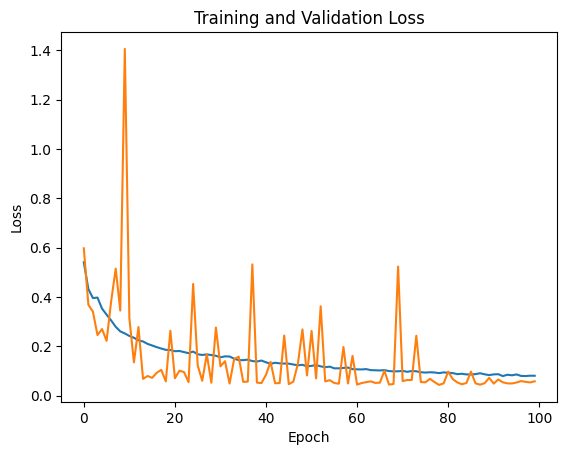

In [382]:
# Plot losses
a = []
for i in range(len(loss_track)):
    a.append(loss_track[i].to("cpu"))

b = []
for i in range(len(valid_loss_track)):
    b.append(valid_loss_track[i].to("cpu"))

plt.plot(range(len(a)), a, label="Training Loss")
plt.plot(range(len(b)), b, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [383]:
tp, fp, tn, fn = 0, 0, 0, 0

actual_test = []
predicted_test = []

for batch in test_dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.to(torch.int64)

    model.eval()
    with torch.no_grad():
        output = model(inputs)

    output = nn.functional.softmax(output, dim=1)

    actual_test.append(labels)
    predicted_test.append(output)

    for i, v in enumerate(output):
        if labels[i] == torch.tensor([1]).to(device):
            if v[1] >= v[0]:
                tp += 1
            else:
                fp += 1
        elif labels[i] == torch.tensor([0]).to(device):
            if v[0] >= v[1]:
                tn += 1
            else:
                fn += 1

In [184]:
s = 55
m = nn.Softmax(dim=1)
a = m(predicted_test[s])
a1 = a[0]
a11 = round(float(a1[0]), 10)
a12 = round(float(a1[1]), 10)

a2 = a[1]
a21 = round(float(a2[0]), 10)
a22 = round(float(a2[1]), 10)
print(a11, a12)
print(a21, a22)
print(actual_test[s])

0.6855210066 0.3144789636
0.7289384604 0.27106148
tensor([0, 0], device='cuda:0')


In [384]:
sensitivity = (tp) / (tp + fn)
specificity = (tn) / (tn + fp)
precision = (tp) / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Confusion Matrix:")
print(
    f"""
      ////                 Is Seizure, Is Not Seizure
      Is Seizure           {tp} ({round(tp/(tp + tn + fp + fn),2)}%)   {fp}({round(fp/(tp + tn + fp + fn),2)}%)
      Is Not Seizure       {fn} ({round(fn/(tp + tn + fp + fn),2)}%)   {tn}({round(tn/(tp + tn + fp + fn),2)}%)

      Sensitivity: {sensitivity}
      Specificity: {specificity}
      Precision: {precision}
      Accuracy: {accuracy}
      """
)

Confusion Matrix:

      ////                 Is Seizure, Is Not Seizure
      Is Seizure           31 (0.04%)   6(0.01%)
      Is Not Seizure       14 (0.02%)   778(0.94%)

      Sensitivity: 0.6888888888888889
      Specificity: 0.9923469387755102
      Precision: 0.8378378378378378
      Accuracy: 0.9758745476477684
      


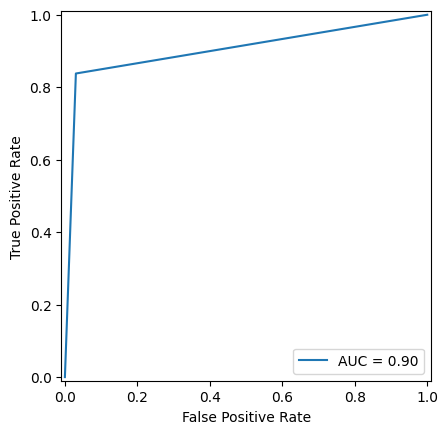

In [366]:
from sklearn import metrics

y_true, y_score = [], []


for i in actual_test:

    for j in i:

        y_true.append(j.to("cpu"))


for i in predicted_test:

    for j in i:

        if j[0] > j[1]:

            y_score.append(0)

        else:

            y_score.append(1)


# y_true = y_true.detach().cpu()


# y_score = y_score.detach().cpu()


fpr, tpr, thresholds = metrics.roc_curve(y_true=y_true, y_score=y_score)


roc_auc = metrics.auc(fpr, tpr)


# dis = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)


# dis.plot()


dis = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
dis.plot()

In [46]:
torch.save(model.state_dict(), "absence while away.pt")

100%|██████████| 177408/177408 [1:47:55<00:00, 29.37it/s]

In [ ]:
model = model
model.load_state_dict(torch.load("mfcc.pt"))